# Incremental SGD for the MovieLens 1M dataset

J. Vinagre, et al., "**Fast incremental matrix factorization for recommendation with positive-only feedback**," Proc. UMAP 2014, pp. 459-470, July 2014.

In [5]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

from ISGD import ISGD

### Load MovieLens 1M dataset

In [3]:
ratings = []
with open('ml-1m/ratings.dat') as f:
    lines = map(lambda l: map(int, l.rstrip().split('::')), f.readlines())
    for l in lines:
        # Since we consider positive-only feedback setting, ratings < 5 will be excluded.
        if l[2] == 5: ratings.append(l)

ratings = np.asarray(ratings)
ratings.shape

TypeError: 'map' object is not subscriptable

In [6]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings_base = pd.read_csv('ml-1m/ratings.dat', sep='::', names=r_cols, encoding='latin-1')

C:\Users\tvlon\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
ratings = ratings_base.values

In [8]:
# sorted by timestamp
ratings = ratings[np.argsort(ratings[:, 3])]
ratings[:10]

array([[     6040,       858,         4, 956703932],
       [     6040,      2384,         4, 956703954],
       [     6040,       593,         5, 956703954],
       [     6040,      1961,         4, 956703977],
       [     6040,      2019,         5, 956703977],
       [     6040,      1419,         3, 956704056],
       [     6040,       213,         5, 956704056],
       [     6040,      3111,         5, 956704056],
       [     6040,       573,         4, 956704056],
       [     6040,      3505,         4, 956704056]], dtype=int64)

In [9]:
users = set([])
items = set([])
for u, i, r, t in ratings:
    users.add(u)
    items.add(i)
users = list(users)
items = list(items)

n_user = len(users)
n_item = len(items)

n_user, n_item

(6040, 3706)

## Run a *test-then-learn* procedure 

Simple Moving Average (SMA) with window size $n=5000$

In [13]:
window_size =100# 5000 # for SMA
N = 10 # recall@10

history_mat = np.zeros((n_user, n_item))

# initialize
isgd = ISGD(n_user, n_item, k=100)

# to avoid cold-start, train initial 20% samples
n_ratings = ratings.shape[0]
n_train = int(n_ratings * 0.2)
for ri in range(n_train):
    u, i, rating, timestamp = ratings[ri]
    u_index = users.index(u)
    i_index = items.index(i)
    isgd.update(u_index, i_index)
    history_mat[u_index, i_index] = 1

avgs = []
sma = []
for ri in range(n_train, n_ratings):
    u, i, rating, timestamp = ratings[ri]
    u_index = users.index(u)
    i_index = items.index(i)
    
    # 1.
    if u_index in isgd.known_users:
        # If u is a known user, use the current model to recommend N items,
        recos = isgd.recommend(u_index, N, history_mat[u_index])
        
        # 2. Score the recommendation list given the true observed item i
        recall = 1 if (i_index in recos) else 0
        
        sma.append(recall)
        n = len(sma)
        if n > window_size: 
            del sma[0]
            n -= 1
        avgs.append(sum(sma) / float(n))
    
    # 3. update the model with the observed event
    isgd.update(u_index, i_index)
    history_mat[u_index, i_index] = 1

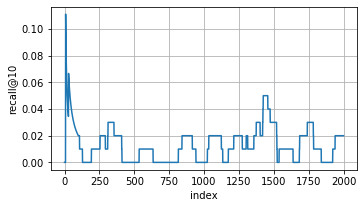

In [19]:
fig, ax = plt.subplots()
ax.plot(range(len(avgs[:2000])), avgs[:2000])
ax.set_xlabel('index')
ax.set_ylabel('recall@10')
ax.grid(True)
#ax.set_xticks([0, 50000, 100000, 150000])
#ax.set_yticks([0.00, 0.05, 0.10, 0.15])
fig.set_size_inches((5.5,3))
fig.patch.set_alpha(0.0)